# Classify Groups

## Census Tracts

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ---------- 数据加载 ----------
PROCESSED_DATA_DIR = "../../data/processed data"
acs = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "cleaned_acs_data.csv"))

In [36]:
def export_cluster_centers_to_tex(
    cluster_centers_df: pd.DataFrame,
    file_path: str = "cluster_centers_table.tex",
    caption: str = "Cluster Centers Based on Socioeconomic Characteristics",
    label: str = "tab:cluster_centers",
    var_labels: dict = None,
    cluster_names: dict = None,  # 传入例如 {0: "Low Income", 1: ..., 2: ...}
    float_format: str = ".2f",
    column_order: list = None    # 传入例如 ["Low Income", "Middle Income", "High Income"]
):
    import os

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    df = cluster_centers_df.copy().T  # 行为变量，列为 cluster id
    df.index.name = "Variable"

    # 可选变量标签替换
    if var_labels:
        df.index = [var_labels.get(v, v) for v in df.index]

    # === 构造最终输出顺序 ===
    if column_order and cluster_names:
        # 将 column_order 中的名称（如 "Low Income"）反向映射为 cluster id（如 0, 1, 2）
        inv_cluster_names = {v: k for k, v in cluster_names.items()}
        columns_in_order = [inv_cluster_names[name] for name in column_order if name in inv_cluster_names and inv_cluster_names[name] in df.columns]
    else:
        columns_in_order = df.columns.tolist()

    # 构造列标题
    if cluster_names:
        col_labels = [cluster_names.get(c, f"Cluster {c}") for c in columns_in_order]
    else:
        col_labels = [f"Cluster {c}" for c in columns_in_order]

    tex = []
    tex.append("\\begin{table}[H]\\centering")
    tex.append(f"\\caption{{{caption}}}")
    tex.append(f"\\label{{{label}}}")
    tex.append("\\footnotesize")
    tex.append(f"\\begin{{tabular}}{{l{'c' * len(columns_in_order)}}}")
    tex.append("\\toprule")
    tex.append(" & " + " & ".join(col_labels) + " \\\\")
    tex.append("\\midrule")

    for row_label in df.index:
        row = [row_label] + [f"{df.loc[row_label, c]:{float_format}}" for c in columns_in_order]
        tex.append(" & ".join(str(x) for x in row) + " \\\\")

    tex.append("\\bottomrule")
    tex.append("\\end{tabular}")
    tex.append("\\vspace{0.5em}")
    tex.append("\\begin{minipage}{0.95\\textwidth}\\footnotesize\\textit{Notes:} This table reports the inverse-transformed cluster centers derived from K-means clustering on standardized socioeconomic variables.\\end{minipage}")
    tex.append("\\end{table}")

    with open(file_path, "w", encoding="utf-8") as f:
        f.write("\n".join(tex))

    print(f"LaTeX cluster center table saved to: {file_path}")


In [31]:
def export_pca_loadings_to_tex(
    loadings_df: pd.DataFrame,
    file_path: str = "pca_loadings_table.tex",
    caption: str = "PCA Loadings on Socioeconomic Variables",
    label: str = "tab:pca_loadings",
    var_labels: dict = None,
    float_format: str = ".3f"
):
    import os

    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    df = loadings_df.copy()
    df.index.name = "Variable"

    # 可选变量标签替换
    if var_labels:
        df.index = [var_labels.get(v, v) for v in df.index]

    columns = df.columns.tolist()
    index = df.index.tolist()

    tex = []
    tex.append("\\begin{table}[H]\\centering")
    tex.append(f"\\caption{{{caption}}}")
    tex.append(f"\\label{{{label}}}")
    tex.append("\\footnotesize")
    tex.append(f"\\begin{{tabular}}{{l{'c' * len(columns)}}}")
    tex.append("\\toprule")
    tex.append(" & " + " & ".join(columns) + " \\\\")
    tex.append("\\midrule")

    for row_label, row_vals in zip(index, df.values):
        row = [row_label] + [f"{v:{float_format}}" for v in row_vals]
        tex.append(" & ".join(row) + " \\\\")

    tex.append("\\bottomrule")
    tex.append("\\end{tabular}")
    tex.append("\\vspace{0.5em}")
    tex.append("\\begin{minipage}{0.95\\textwidth}\\footnotesize\\textit{Notes:} This table reports the loadings of the first two principal components extracted from standardized socioeconomic variables. Loadings represent the contribution of each original variable to the corresponding principal component.\\end{minipage}")
    tex.append("\\end{table}")

    with open(file_path, "w", encoding="utf-8") as f:
        f.write("\n".join(tex))

    print(f"LaTeX PCA loadings table saved to: {file_path}")

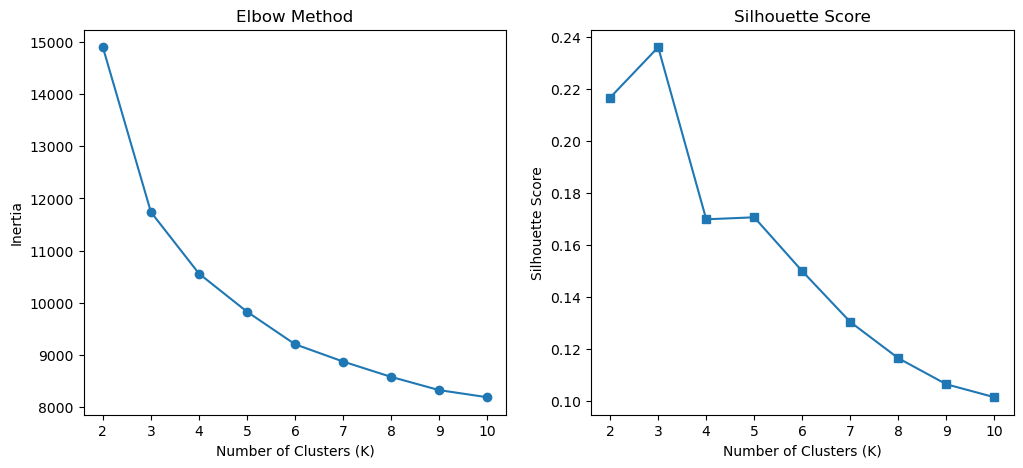

🔹 Optimal number of clusters: 3


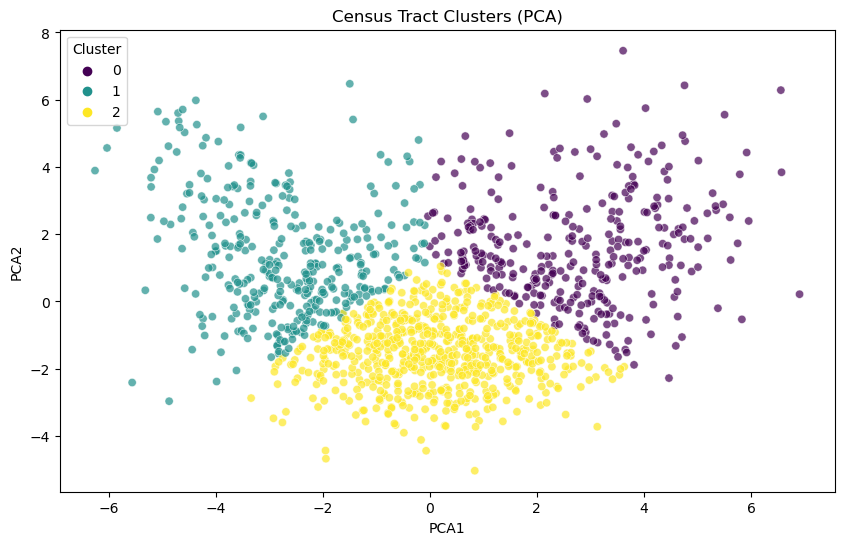

✅ Clustered data saved with cluster labels.

🔍 Cluster Centers (Restored to Original Scale):
            MEDINC  INCPERCAP  INC_LT10K  INC_10_15K  INC_15_25K  INC_25_35K  \
Cluster                                                                        
0         33951.60   19335.87      89.55       44.78      106.39       81.09   
1        110398.95   59679.78      26.87       11.36       35.49       41.51   
2         62719.75   31742.69      88.58       45.94      137.38      140.94   

         INC_35_50K  INC_50_75K  INC_75_100K  INC_100_150K  INC_150_200K  \
Cluster                                                                    
0             92.66       99.98        51.01         48.31          8.61   
1             70.76      143.08       133.75        222.35        140.53   
2            200.04      307.43       224.53        271.46         97.28   

         INC_GT200K  POVERTY_RATE    SNAP  SS_INCOME  
Cluster                                               
0              

In [32]:

VARIABLES = {
    "MEDINC": "DP03_0062E",          # Median Household Income
    "INCPERCAP": "DP03_0088E",       # Per Capita Income
    "INC_LT10K": "DP03_0052E",
    "INC_10_15K": "DP03_0053E",
    "INC_15_25K": "DP03_0054E",
    "INC_25_35K": "DP03_0055E",
    "INC_35_50K": "DP03_0056E",
    "INC_50_75K": "DP03_0057E",
    "INC_75_100K": "DP03_0058E",
    "INC_100_150K": "DP03_0059E",
    "INC_150_200K": "DP03_0060E",
    "INC_GT200K": "DP03_0061E",
    "POVERTY_RATE": "DP03_0119PE",   # %
    "SNAP": "DP03_0074E",
    "SS_INCOME": "DP03_0066E",
}

# 变量名 → 友好名称（可选）
VARIABLE_LABELS = {
    "MEDINC": "Median Household Income",
    "INCPERCAP": "Per Capita Income",
    "INC_LT10K": "Income < 10k",
    "INC_10_15K": "Income 10k–15k",
    "INC_15_25K": "Income 15k–25k",
    "INC_25_35K": "Income 25k–35k",
    "INC_35_50K": "Income 35k–50k",
    "INC_50_75K": "Income 50k–75k",
    "INC_75_100K": "Income 75k–100k",
    "INC_100_150K": "Income 100k–150k",
    "INC_150_200K": "Income 150k–200k",
    "INC_GT200K": "Income > 200k",
    "POVERTY_RATE": "Poverty Rate (\%)",
    "SNAP": "Households on SNAP",
    "SS_INCOME": "Households with Social Security"
}

features = list(VARIABLES.keys())
log_transform_vars = [
    "MEDINC", "INCPERCAP", "SNAP", "POVERTY_RATE", "SS_INCOME"
] + [f for f in features if f.startswith("INC_")]

# ---------- 清洗 & 转换 ----------
acs_filtered = acs.dropna(subset=features).copy()

# 记录用于逆变换
acs_transformed = acs_filtered.copy()

# ✅ log1p 变换（仅指定变量）
for var in log_transform_vars:
    acs_transformed[var] = np.log1p(acs_transformed[var])

# ---------- 标准化 ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(acs_transformed[features])

# ---------- KMeans 聚类 ----------
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# 绘图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker="s")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

# ---------- 最佳 K 聚类 ----------
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"🔹 Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
acs_filtered["Cluster"] = kmeans.fit_predict(X_scaled)

# ---------- PCA 可视化 ----------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
acs_filtered["PCA1"] = X_pca[:, 0]
acs_filtered["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=acs_filtered, palette="viridis", alpha=0.7)
plt.title("Census Tract Clusters (PCA)")
plt.show()

# ---------- 合并并保存结果 ----------
acs_filtered["GEOID"] = acs_filtered["GEOID"].astype(int)
acs["GEOID"] = acs["GEOID"].astype(int)
acs = acs.merge(acs_filtered[["GEOID", "Cluster"]], on="GEOID", how="left")
acs.to_csv(os.path.join(PROCESSED_DATA_DIR, "census_tract_clusters.csv"), index=False)
print("✅ Clustered data saved with cluster labels.")

# ---------- 反变换聚类中心 ----------
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_log = scaler.inverse_transform(cluster_centers_scaled)

# 对 log 变量执行 expm1 逆变换
cluster_centers_restored = pd.DataFrame(cluster_centers_log, columns=features)
for var in log_transform_vars:
    cluster_centers_restored[var] = np.expm1(cluster_centers_restored[var])

# 输出表格
cluster_centers_restored["Cluster"] = range(optimal_k)
cluster_centers_df = cluster_centers_restored.set_index("Cluster")

print("\n🔍 Cluster Centers (Restored to Original Scale):")
print(cluster_centers_df.round(2))

# ---------- 获取 PCA 载荷（loadings） ----------
loadings = pd.DataFrame(
    data=pca.components_.T,
    index=features,
    columns=["PC1", "PC2"]
)

In [33]:
export_pca_loadings_to_tex(
    loadings_df=loadings,
    file_path="../../output/classify/pca_loadings.tex",
    caption="PCA Loadings on Socioeconomic Variables",
    label="tab:pca_loadings",
    var_labels=VARIABLE_LABELS
)

LaTeX PCA loadings table saved to: ../../output/classify/pca_loadings.tex


In [37]:
CLUSTER_NAMES = {
    0: "Low Income",
    1: "High Income",
    2: "Middle Income"
}

export_cluster_centers_to_tex(
    cluster_centers_df=cluster_centers_df,
    file_path="../../output/classify/cluster_centers_table.tex",
    caption="Cluster Centers Based on Census Tract Socioeconomic Indicators",
    label="tab:cluster_centers",
    var_labels=VARIABLE_LABELS,
    cluster_names=CLUSTER_NAMES,  # ← 添加这行即可
    column_order=["Low Income", "Middle Income", "High Income"]
)


LaTeX cluster center table saved to: ../../output/classify/cluster_centers_table.tex
